# Summary of overlapped genes (expressed)

In [1]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, fisher_exact, chi2_contingency
import matplotlib.pyplot as plt
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader

In [2]:
with BedFile("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.transcripts.bed.gz") as f:
    transcripts = {t.name: t for t in f}
print("All transcripts: %d" % len(transcripts))

anno = pd.read_csv("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.tsv", sep="\t")
for tid, ttype, gid, gtype, gname in anno[["TranscriptID", "TranscriptType", "GeneID", "GeneType", "GeneName"]].values:
    t = transcripts[tid]
    t.transcript_type = ttype
    t.gene_id = gid
    t.gene_type = gtype
    t.gene_name = gname
genes = []
data = defaultdict(list)
for t in transcripts.values():
    data[t.gene_id].append(t)
for gid, ts in data.items():
    g = GRange(chrom=ts[0].chrom, 
               start=min([t.start for t in ts]), 
               end=max([t.end for t in ts]), 
               strand=ts[0].strand, 
               name=gid)
    g.gene_name = ts[0].gene_name
    g.gene_type = ts[0].gene_type
    g.transcripts = ts
    genes.append(g)
print("All genes: %d" % len(genes))

genes = list(filter(lambda g: g.chrom != "chrM", genes))
print("Not chrM genes: %d" % len(genes))

genes = list(filter(lambda g: g.gene_type == "protein_coding", genes))
print("Protein coding genes: %d" % len(genes))

tmp = list(filter(lambda g: g.gene_name.startswith("ENSG"), genes))
print("Potential fusion genes: %d" % len(tmp))

genes = list(filter(lambda g: not g.gene_name.startswith("ENSG"), genes))
print("Filtered genes: %d" % len(genes))

All transcripts: 244939
All genes: 61533
Not chrM genes: 61496
Protein coding genes: 19969
Potential fusion genes: 594
Filtered genes: 19375


In [3]:
def get_halflife(total, nascent):
    if total == 0:
        return np.nan
    elif nascent == 0:
        return np.inf
    elif total == nascent:
        return 0
    else:
        return -3 / np.log2(1-nascent/total)

# 这里需要改成实验组的细胞结果
m = pd.read_csv("../../1_FLAIRseq/reports/gene_based/K562.all_cells.min_read_2_min_tc_2.annotated.tsv", sep="\t")
m = m[m["Total"] > 0]
data = {g.name: g for g in genes}
for gid, total, nascent, tpm in m[["GeneID", "Total", "Nascent", "TPM"]].values:
    if gid in data:
        g = data[gid]
        g.total = total
        g.nascent = nascent
        g.ntr = nascent / total
        g.halflife = get_halflife(total, nascent)
        g.tpm = tpm

m = pd.read_csv("../../1_FLAIRseq/reports/transcript_based/K562.treatment_cells.min_read_2_min_tc_2.annotated.tsv", sep="\t")
m = m[m["Total"] > 0]
for tid, total, nascent, tpm in m[["TranscriptID", "Total", "Nascent", "TPM"]].values:
    t = transcripts[tid]
    t.total = total
    t.nascent = nascent
    t.ntr = nascent / total
    t.halflife = get_halflife(total, nascent)
    t.tpm = tpm

array = []
for g in genes:
    try:
        if g.tpm >= 10:
            array.append(g)
    except AttributeError:
        pass
genes = array
print("Expressed genes: %d" % len(genes))

Expressed genes: 7547


In [4]:
loader = ShiftLoader(genes)
counter = defaultdict(int)
for g1 in genes:
    overlap_genes = []
    n1 = 0 # sense
    n2 = 0 # ansti-sense
    for g2 in loader.fetch(obj=g1):
        if g2 is not g1:
            if g1.strand == g2.strand:
                n1 += 1
            else:
                n2 += 1
            overlap_genes.append(g2)
    g1.overlap_genes = overlap_genes
    counter[(n1 > 0, n2 > 0)] += 1
print(counter)

defaultdict(<class 'int'>, {(False, False): 6012, (False, True): 1327, (True, False): 166, (True, True): 42})


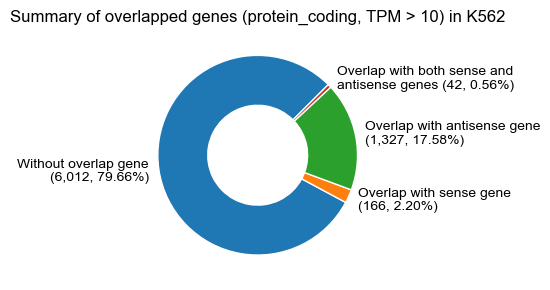

In [5]:
vs = [counter[(False, False)], counter[(True, False)], counter[(False, True)], counter[(True, True)]]
labels = [
    "Without overlap gene\n(%s, %.2f%%)" % (format(vs[0], ","), vs[0]*100/sum(vs)),
    "Overlap with sense gene\n(%s, %.2f%%)" % (format(vs[1], ","), vs[1]*100/sum(vs)),
    "Overlap with antisense gene\n(%s, %.2f%%)" % (format(vs[2], ","), vs[2]*100/sum(vs)),
    "Overlap with both sense and \nantisense genes (%s, %.2f%%)" % (format(vs[3], ","), vs[3]*100/sum(vs))]
plt.figure(figsize=(5.5, 3))
plt.title("Summary of overlapped genes (protein_coding, TPM > 10) in K562")
plt.pie(vs, colors=["C0", "C1", "C2", "C3"], radius=1, startangle=45,
        # autopct='%1.1f%%', pctdistance=0.8,
        wedgeprops=dict(width=0.5, edgecolor='w'), labels=labels)
plt.tight_layout()
plt.savefig("figures/summary_of_overlap_genes.pie.pdf")

In [29]:
rows = []
for g1 in genes:
    for g2 in g1.overlap_genes:
        
        row = [g1.name, g1.gene_name, g1.gene_type, g1.strand, 
               g1.tpm, g1.total, g1.nascent, g1.ntr, g1.halflife,
               len(overlap_genes),
               g2.name, g2.gene_name, g2.gene_type, g2.strand,
               g2.tpm, g2.total, g2.nascent, g2.ntr, g2.halflife,
              ]
        rows.append(row)
        
m = pd.DataFrame(rows, 
                 columns=["GeneID", "GeneName", "GeneType", "Strand", "TPM", "Total", "Nascent", "NTR", "Halflife",
                          "OverlappedGeneNumber", 
                          "GeneID.Overlapped", "GeneName.Overlapped", "GeneType.Overlapped", "Strand.Overlapped",
                          "TPM.Overlapped", "Total.Overlapped", "Nascent.Overlapped", "NTR.Overlapped", "Halflife.Overlapped"])
ps1 = []
ps2 = []
for v1, v2, v3, v4 in m[["Total", "Nascent", "Total.Overlapped", "Nascent.Overlapped"]].values:
    ps1.append(fisher_exact([[v1-v2, v2], [v3-v4, v4]])[1])
    if v2 == 0 and v4 == 0:
        ps2.append(1)
    else:
        ps2.append(chi2_contingency([[v1-v2, v2], [v3-v4, v4]])[1])
m["Pval.Fisher"] = ps1
m["Pval.Chi2"] = ps2
m["T.Log2FC"] = np.log2(m["Halflife.Overlapped"]/m["Halflife"])
m["NTR.Diff"] = m["NTR.Overlapped"] - m["NTR"]
m.to_csv("results/expressed_overlap_genes.tsv", sep="\t", index=False)
m.head()

/home/chenzonggui/miniconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,GeneID,GeneName,GeneType,Strand,TPM,Total,Nascent,NTR,Halflife,OverlappedGeneNumber,...,Strand.Overlapped,TPM.Overlapped,Total.Overlapped,Nascent.Overlapped,NTR.Overlapped,Halflife.Overlapped,Pval.Fisher,Pval.Chi2,T.Log2FC,NTR.Diff
0,ENSG00000131584.19,ACAP3,protein_coding,-,20.677662,60,9,0.150000,12.795073,0,...,+,102.009800,296,13,0.043919,46.299781,0.005035,4.836583e-03,1.855417,-0.106081
1,ENSG00000169972.12,PUSL1,protein_coding,+,102.009800,296,13,0.043919,46.299781,0,...,-,20.677662,60,9,0.150000,12.795073,0.005035,4.836583e-03,-1.855417,0.106081
2,ENSG00000169972.12,PUSL1,protein_coding,+,102.009800,296,13,0.043919,46.299781,0,...,-,127.512250,370,17,0.045946,44.210563,1.000000,1.000000e+00,-0.066614,0.002027
3,ENSG00000127054.22,INTS11,protein_coding,-,127.512250,370,17,0.045946,44.210563,0,...,+,102.009800,296,13,0.043919,46.299781,1.000000,1.000000e+00,0.066614,-0.002027
4,ENSG00000157916.20,RER1,protein_coding,+,331.531849,962,40,0.041580,48.963489,0,...,-,17.231385,50,11,0.220000,8.369275,0.000015,1.214106e-07,-2.548532,0.178420


25 6


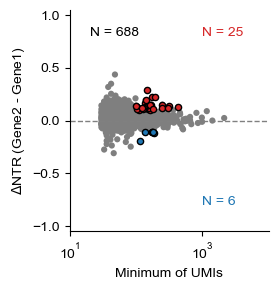

In [30]:
m = m[m["Strand"] != m['Strand.Overlapped']]
m = m[~m["GeneID"].duplicated()]
flags1 = m["Total"] > m["Total.Overlapped"]
flags2 = (m["Total"] == m["Total.Overlapped"]) & (m["GeneID"] > m["GeneID.Overlapped"])
m = m[flags1 | flags2]

min_umi = 100
xs, ys = m["Total.Overlapped"], m["NTR.Diff"]
m1 = m[(m["T.Log2FC"] < -1) & (m["NTR.Diff"] > 0.1) & (m["Pval.Fisher"] < 1) & (m["Total"] >= min_umi) & (m["Total.Overlapped"] >= min_umi)]
m2 = m[(m["T.Log2FC"] > 1) & (m["NTR.Diff"] < -0.1) & (m["Pval.Fisher"] < 1) & (m["Total"] >= min_umi) & (m["Total.Overlapped"] >= min_umi)]
xs1, ys1 = m1["Total.Overlapped"], m1["NTR.Diff"]
xs2, ys2 = m2["Total.Overlapped"], m2["NTR.Diff"]
print(len(m1), len(m2))
plt.figure(figsize=(3, 3))
plt.axhline(0, lw=1, ls="--", color="grey")
plt.scatter(xs, ys, edgecolor="none", color="C7", s=20)
plt.scatter(xs1, ys1, edgecolor="black", color="C3", s=20)
plt.scatter(xs2, ys2, edgecolor="black", color="C0", s=20)
plt.text(20, 0.8, "N = %d" % len(m), color="black")
plt.text(1000, 0.8, "N = %d" % len(m1), color="C3")
plt.text(1000, -0.8, "N = %d" % len(m2), color="C0")
plt.xscale("log")
plt.xlim(10, 10000)
plt.ylim(-1.05, 1.05)
plt.xlabel("Minimum of UMIs")
plt.ylabel("$\Delta$NTR (Gene2 - Gene1)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
# plt.savefig("figures/difference_ntr_sense_antisense.pdf")

In [89]:
array = list(sorted(transcripts.values()))
loader = ShiftLoader(array)
for t1 in array:
    overlap_transcripts = []
    for t2 in loader.fetch(obj=t1):
        if t1.gene_id != t2.gene_id:
            overlap_transcripts.append(t2)
    t1.overlap_transcripts = overlap_transcripts

In [118]:
rows = []
for t1 in array:
    try:
        if t1.tpm >= 10:
            for t2 in t1.overlap_transcripts:
                try:
                    if t2.tpm >= 10:
                        row = [t1.name, t1.gene_id, t1.gene_name, t1.strand, t1.total, t1.nascent, t1.ntr, t1.halflife, 
                               t2.name, t2.gene_id, t2.gene_name, t2.strand, t2.total, t2.nascent, t2.ntr, t2.halflife]
                        rows.append(row)
                except AttributeError:
                    pass
    except AttributeError:
        pass

In [119]:
df = pd.DataFrame(rows, 
                  columns=["TranscriptID", "GeneID", "GeneName", "Strand", "Total", "Nascent", "NTR", "Halflife", 
                           "TranscriptID.2", "GeneID.2", "GeneName.2", "Strand.2", "Total.2", "Nascent.2", "NTR.2", "Halflife.2"])
df.to_csv("results/expressed_overlap_transcripts.tsv", sep="\t", index=False)

In [7]:
df = pd.read_csv("../../1_FLAIRseq/reports/gene_based/K562.treatment_cells.min_read_2_min_tc_2.annotated.tsv", sep="\t")
df.index = df["GeneName"]
del df["Total.Alleles"]
del df["Nascent.Alleles"]
df.loc[["WDR83", "DHPS", "YRDC", 'C1orf122', 'CEBPZ', 'CEBPZOS']]

,GeneID,Total,Nascent,NTR,TPM,T,TranscriptID,TranscriptType,GeneType,GeneName,Chrom,Start,End,Strand,Canonical,Length
GeneName,,,,,,,,,,,,,,,,
WDR83,ENSG00000123154.12,11,5,0.454545,14.322656,3.430653,ENST00000418543.8,protein_coding,protein_coding,WDR83,chr19,12666806.0,12675832.0,+,True,9026.0
DHPS,ENSG00000095059.17,63,4,0.063492,82.029755,31.700117,ENST00000210060.12,protein_coding,protein_coding,DHPS,chr19,12675716.0,12681880.0,-,True,6164.0
YRDC,ENSG00000196449.4,41,32,0.780488,53.384444,1.371349,ENST00000373044.3,protein_coding,protein_coding,YRDC,chr1,37802944.0,37808208.0,-,True,5264.0
C1orf122,ENSG00000197982.14,68,15,0.220588,88.540053,8.343940,ENST00000373042.5,protein_coding,protein_coding,C1orf122,chr1,37807789.0,37809454.0,+,True,1665.0
CEBPZ,ENSG00000115816.15,54,27,0.500000,70.311218,3.000000,ENST00000234170.10,protein_coding,protein_coding,CEBPZ,chr2,37201611.0,37231596.0,-,True,29985.0
CEBPZOS,ENSG00000218739.10,84,5,0.059524,109.373006,33.884263,ENST00000397064.6,protein_coding,protein_coding,CEBPZOS,chr2,37196487.0,37213725.0,+,True,17238.0


# 20240729

In [49]:
with BedFile("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.transcripts.bed.gz") as f:
    transcripts = {t.name: t for t in f}
print("All transcripts: %d" % len(transcripts))

anno = pd.read_csv("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.tsv", sep="\t")
for tid, ttype, gid, gtype, gname in anno[["TranscriptID", "TranscriptType", "GeneID", "GeneType", "GeneName"]].values:
    t = transcripts[tid]
    t.transcript_type = ttype
    t.gene_id = gid
    t.gene_type = gtype
    t.gene_name = gname
    
genes = []
data = defaultdict(list)
for t in transcripts.values():
    data[t.gene_id].append(t)
for gid, ts in data.items():
    g = GRange(chrom=ts[0].chrom, 
               start=min([t.start for t in ts]), 
               end=max([t.end for t in ts]), 
               strand=ts[0].strand, 
               name=gid)
    g.gene_name = ts[0].gene_name
    g.gene_type = ts[0].gene_type
    g.transcripts = ts
    genes.append(g)
genes.sort()
print("All genes: %d" % len(genes))

genes = list(filter(lambda g: g.chrom != "chrM", genes))
print("Not chrM genes: %d" % len(genes))
genes = list(filter(lambda g: g.gene_type == "protein_coding" or g.gene_type == "lncRNA", genes))
print("Protein coding or lncRNA genes: %d" % len(genes))
# tmp = list(filter(lambda g: g.gene_name.startswith("ENSG"), genes))
# print("Potential fusion genes: %d" % len(tmp))
# genes = list(filter(lambda g: not g.gene_name.startswith("ENSG"), genes))
# print("Filtered genes: %d" % len(genes))

All transcripts: 244939
All genes: 61533
Not chrM genes: 61496
Protein coding or lncRNA genes: 37724


In [50]:
def get_halflife(total, nascent):
    if total == 0:
        return np.nan
    elif nascent == 0:
        return np.inf
    elif total == nascent:
        return 0
    else:
        return -3 / np.log2(1-nascent/total)

# 这里需要改成实验组的细胞结果
m = pd.read_csv("../../1_FLAIRseq/reports/gene_based/K562.all_cells.min_read_2_min_tc_2.annotated.tsv", sep="\t")
m = m[m["Total"] > 0]
data = {g.name: g for g in genes}
for g in genes:
    g.total = 0
    g.nascent = 0
    g.ntr = np.nan
    g.halflife = np.nan
    g.tpm = 0
for gid, total, nascent, tpm in m[["GeneID", "Total", "Nascent", "TPM"]].values:
    if gid in data:
        g = data[gid]
        g.total = total
        g.nascent = nascent
        g.ntr = nascent / total
        g.halflife = get_halflife(total, nascent)
        g.tpm = tpm

m = pd.read_csv("../../1_FLAIRseq/reports/transcript_based/K562.treatment_cells.min_read_2_min_tc_2.annotated.tsv", sep="\t")
m = m[m["Total"] > 0]
for t in transcripts.values():
    t.total = 0
    t.nascent = 0
    t.ntr = np.nan
    t.halflife = np.nan
    t.tpm = 0
for tid, total, nascent, tpm in m[["TranscriptID", "Total", "Nascent", "TPM"]].values:
    t = transcripts[tid]
    t.total = total
    t.nascent = nascent
    t.ntr = nascent / total
    t.halflife = get_halflife(total, nascent)
    t.tpm = tpm

# array = []
# for g in genes:
#     try:
#         if g.tpm >= 10:
#             array.append(g)
#     except AttributeError:
#         pass
# genes = array
# print("Expressed genes: %d" % len(genes))

--------------------------------------------------------------------------------
protein_coding: True
lncRNA: True
Min TPM: 0
----------------------------------------
Count	(Biotype,SenseBiotype,AntiSenseBiotype)
----------------------------------------
8665	('protein_coding', (), ())
6435	('lncRNA', (), ())
4862	('lncRNA', (), ('protein_coding',))
2758	('protein_coding', (), ('lncRNA',))
2431	('protein_coding', (), ('protein_coding',))
1770	('lncRNA', (), ('lncRNA',))
1126	('lncRNA', ('protein_coding',), ())
928	('protein_coding', ('protein_coding',), ())
603	('lncRNA', ('lncRNA',), ())
568	('protein_coding', (), ('lncRNA', 'protein_coding'))


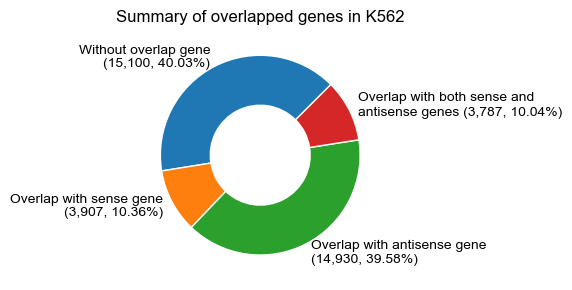

--------------------------------------------------------------------------------
protein_coding: True
lncRNA: False
Min TPM: 0
----------------------------------------
Count	(Biotype,SenseBiotype,AntiSenseBiotype)
----------------------------------------
13209	('protein_coding', (), ())
3474	('protein_coding', (), ('protein_coding',))
1446	('protein_coding', ('protein_coding',), ())
494	('protein_coding', (), ('protein_coding', 'protein_coding'))
488	('protein_coding', ('protein_coding', 'protein_coding'), ())
379	('protein_coding', ('protein_coding',), ('protein_coding',))
140	('protein_coding', ('protein_coding', 'protein_coding'), ('protein_coding',))
60	('protein_coding', ('protein_coding', 'protein_coding', 'protein_coding'), ())
60	('protein_coding', ('protein_coding',), ('protein_coding', 'protein_coding'))
58	('protein_coding', (), ('protein_coding', 'protein_coding', 'protein_coding'))


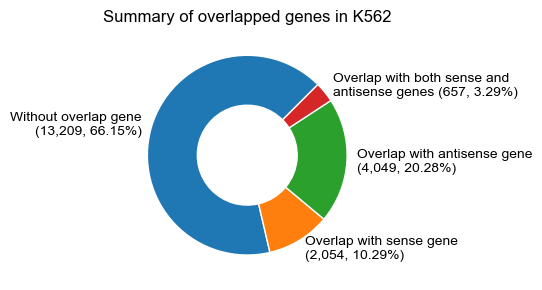

--------------------------------------------------------------------------------
protein_coding: True
lncRNA: True
Min TPM: 10
----------------------------------------
Count	(Biotype,SenseBiotype,AntiSenseBiotype)
----------------------------------------
5894	('protein_coding', (), ())
1202	('protein_coding', (), ('protein_coding',))
212	('protein_coding', ('protein_coding',), ())
180	('lncRNA', (), ())
106	('protein_coding', (), ('protein_coding', 'protein_coding'))
59	('protein_coding', (), ('lncRNA',))
55	('lncRNA', (), ('protein_coding',))
40	('protein_coding', ('protein_coding',), ('protein_coding',))
25	('protein_coding', ('protein_coding', 'protein_coding'), ())
20	('lncRNA', ('protein_coding',), ())


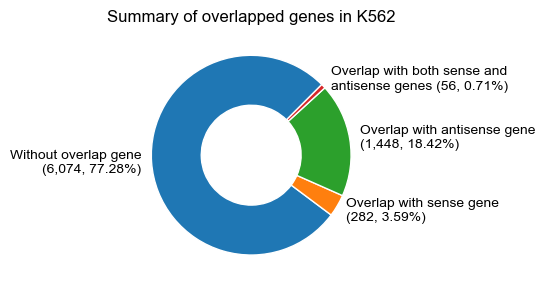

--------------------------------------------------------------------------------
protein_coding: True
lncRNA: False
Min TPM: 10
----------------------------------------
Count	(Biotype,SenseBiotype,AntiSenseBiotype)
----------------------------------------
5972	('protein_coding', (), ())
1216	('protein_coding', (), ('protein_coding',))
212	('protein_coding', ('protein_coding',), ())
106	('protein_coding', (), ('protein_coding', 'protein_coding'))
42	('protein_coding', ('protein_coding',), ('protein_coding',))
26	('protein_coding', ('protein_coding', 'protein_coding'), ())
3	('protein_coding', ('protein_coding', 'protein_coding'), ('protein_coding',))
3	('protein_coding', ('protein_coding', 'protein_coding', 'protein_coding'), ())
3	('protein_coding', (), ('protein_coding', 'protein_coding', 'protein_coding'))
3	('protein_coding', ('protein_coding',), ('protein_coding', 'protein_coding'))


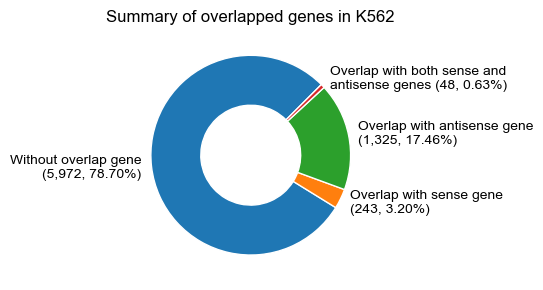

In [51]:
protein_coding = True
lnc_rna = False
min_tpm = 10

def profile(genes, protein_coding, lnc_rna, min_tpm):
    print("-" * 80)
    print("protein_coding:", protein_coding)
    print("lncRNA:", lnc_rna)
    print("Min TPM:", min_tpm)
    
    genes1 = []
    for g in genes:
        keep = False
        if protein_coding and g.gene_type == "protein_coding":
            keep = True
        elif lnc_rna and g.gene_type == "lncRNA":
            keep = True
        if g.tpm < min_tpm:
            keep = False
        if keep:
            genes1.append(g)
    
    loader = ShiftLoader(genes1)
    counter = defaultdict(int)
    counter2 = defaultdict(int)
    for g1 in genes1:
        overlap_genes = []
        n1 = 0 # sense
        n2 = 0 # ansti-sense
        for g2 in loader.fetch(obj=g1):
            if g2 is not g1:
                if g1.strand == g2.strand:
                    n1 += 1
                else:
                    n2 += 1
                overlap_genes.append(g2)
        g1.overlap_genes = overlap_genes
        counter[(n1 > 0, n2 > 0)] += 1

        k = (
            g1.gene_type,
            tuple(sorted([g3.gene_type for g3 in filter(lambda x: x.strand == g1.strand, overlap_genes)])),
            tuple(sorted([g3.gene_type for g3 in filter(lambda x: x.strand != g1.strand, overlap_genes)])),
        )
        counter2[k] += 1
    # print(counter)
    print("-" * 40)
    print("Count\t(Biotype,SenseBiotype,AntiSenseBiotype)")
    print("-" * 40)
    for i, (k, v) in enumerate(sorted(counter2.items(), key=lambda x: x[1], reverse=True)):
        if i >= 10:
            break
        print(v, k, sep="\t")
    
    vs = [counter[(False, False)], counter[(True, False)], counter[(False, True)], counter[(True, True)]]
    labels = [
        "Without overlap gene\n(%s, %.2f%%)" % (format(vs[0], ","), vs[0]*100/sum(vs)),
        "Overlap with sense gene\n(%s, %.2f%%)" % (format(vs[1], ","), vs[1]*100/sum(vs)),
        "Overlap with antisense gene\n(%s, %.2f%%)" % (format(vs[2], ","), vs[2]*100/sum(vs)),
        "Overlap with both sense and \nantisense genes (%s, %.2f%%)" % (format(vs[3], ","), vs[3]*100/sum(vs))]
    plt.figure(figsize=(5.5, 3))
    plt.title("Summary of overlapped genes in K562")
    plt.pie(vs, colors=["C0", "C1", "C2", "C3"], radius=1, startangle=45,
            # autopct='%1.1f%%', pctdistance=0.8,
            wedgeprops=dict(width=0.5, edgecolor='w'), labels=labels)
    plt.tight_layout()
    plt.show()
    plt.close()

profile(genes, protein_coding=True, lnc_rna=True, min_tpm=0)
profile(genes, protein_coding=True, lnc_rna=False, min_tpm=0)
profile(genes, protein_coding=True, lnc_rna=True, min_tpm=10)
profile(genes, protein_coding=True, lnc_rna=False, min_tpm=10)

# 202407310

In [56]:
with BedFile("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.transcripts.bed.gz") as f:
    transcripts = {t.name: t for t in f}
print("All transcripts: %d" % len(transcripts))

anno = pd.read_csv("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.tsv", sep="\t")
for tid, ttype, gid, gtype, gname in anno[["TranscriptID", "TranscriptType", "GeneID", "GeneType", "GeneName"]].values:
    t = transcripts[tid]
    t.transcript_type = ttype
    t.gene_id = gid
    t.gene_type = gtype
    t.gene_name = gname
    
genes = []
data = defaultdict(list)
for t in transcripts.values():
    data[t.gene_id].append(t)
for gid, ts in data.items():
    g = GRange(chrom=ts[0].chrom, 
               start=min([t.start for t in ts]), 
               end=max([t.end for t in ts]), 
               strand=ts[0].strand, 
               name=gid)
    g.gene_name = ts[0].gene_name
    g.gene_type = ts[0].gene_type
    g.transcripts = ts
    genes.append(g)
genes.sort()
print("All genes: %d" % len(genes))

genes = list(filter(lambda g: g.chrom != "chrM", genes))
print("Not chrM genes: %d" % len(genes))
# genes = list(filter(lambda g: g.gene_type == "protein_coding" or g.gene_type == "lncRNA", genes))
# print("Protein coding or lncRNA genes: %d" % len(genes))
# genes = list(filter(lambda g: g.gene_type == "protein_coding", genes))
# print("Protein coding genes: %d" % len(genes))
# tmp = list(filter(lambda g: g.gene_name.startswith("ENSG"), genes))
# print("Potential fusion genes: %d" % len(tmp))
# genes = list(filter(lambda g: not g.gene_name.startswith("ENSG"), genes))
# print("Filtered genes: %d" % len(genes))

All transcripts: 244939
All genes: 61533
Not chrM genes: 61496


In [63]:
array = []
loader = ShiftLoader(genes)
for g1 in genes:
    overlapped_genes = []
    for g2 in loader.fetch(obj=g1):
        if g2 is not g1:
            overlapped_genes.append(g2)
    if len(overlapped_genes) == 0 and g1.gene_type == "protein_coding":
        array.append(g1)
print("protein_coding genes without any overlapped genes:", len(array))

protein_coding genes without any overlapped genes: 6731


In [81]:
paths = [
    "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C01.bed.gz",
    "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C02.bed.gz",
    "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C03.bed.gz",
    "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C04.bed.gz",
    "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C05.bed.gz",
    "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C06.bed.gz",
    "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C07.bed.gz",
    "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C08.bed.gz",
    "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C09.bed.gz",
    "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C10.bed.gz",
    # "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C11.bed.gz",
    # "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C12.bed.gz",
    # "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C13.bed.gz",
    # "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C14.bed.gz",
    # "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C15.bed.gz",
    # "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C16.bed.gz",
    # "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C17.bed.gz",
    # "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C18.bed.gz",
    # "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C19.bed.gz",
    # "../../1_FLAIRseq/results/expression/collapsed/20220719_K562R1/20220719_K562R1.C20.bed.gz",
]
umis = []
for path in paths:
    with BedFile(path) as f:
        for x in f:
            umis.append(x)
umis.sort()
print(len(umis))

181123


In [82]:
n1, n2 = 0, 0
loader = ShiftLoader(array)
for umi in umis:
    gs = []
    for g in loader.fetch(obj=umi):
        gs.append(g)
    if len(gs) == 1:
        if umi.strand == gs[0].strand:
            n1 += 1
        else:
            n2 += 1
print("Same strand: %d" % n1)
print("Different strand: %d" % n2)
print("Strand precision: %f%%" % (n1 * 100 / (n1 + n2)))

Same strand: 46440
Different strand: 654
Strand precision: 98.611288%
